This is needed to reload modules without restarting the kernel

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# Line above avoids running on GPU

In [2]:
%load_ext autoreload
%autoreload 2

This is needed to add eda_tools from the directories above

In [3]:
import os
os.sys.path.append('../../')

# PCA for Feature Encoding

Lets use PCA to reduce the dimensionality of the feature space

In [4]:
!ls -lh /mnt/storage/lborgna/NNT/

total 22G
drwxr-xr-x 11 lborgna users 4.0K Jun 14  2020 bs_test
drwxr-xr-x  3 lborgna users 4.0K Jun 14  2020 buckets
-rw-r--r--  1 lborgna users 5.8G Oct  1  2020 data17_with_weights.root
-rw-r--r--  1 lborgna users 5.8G Oct  1  2020 data3b_17_with_weights.root
-rw-r--r--  1 lborgna users 5.8G Oct  1  2020 data3b1j_17_with_weights.root
drwxr-xr-x  3 lborgna users 4.0K Nov 27 16:02 JUN20
drwxr-xr-x  3 lborgna users 4.0K May 23  2020 MAY20-1
-rw-r--r--  1 lborgna users 5.7M Oct 23 16:54 MC16d_trigStudies.tm.nominal.parquet
drwxr-xr-x  2 lborgna users 4.0K Nov 27 09:42 MDR
drwxr-xr-x  4 lborgna users 4.0K Apr  5 17:55 MDR_VEC
drwxr-xr-x  2 lborgna users 4.0K Nov 27 09:56 min_dR1
drwxr-xr-x  2 lborgna users 4.0K Oct 29 23:43 NNT_noBucketsNominal
drwxr-xr-x  3 lborgna users 4.0K Feb 17 23:43 nr-2b2j
drwxr-xr-x  5 lborgna users 4.0K Feb 16 15:45 nr-bucket-JAN21
-rw-r--r--  1 lborgna users 3.4M Oct 24 17:12 optimization_non_resonant_results.parquet
drwxr-xr-x  2 lborgna users 4.0K Dec  3 23:

In [5]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import tensorflow as tf

In [7]:
tf.__version__

'2.1.0'

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#import keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import  BatchNormalization


In [9]:
import shap

In [10]:
f = uproot.open('/mnt/storage/lborgna/NNT/data17_with_weights.root')

In [11]:
f.keys()

[b'validation;1',
 b'control;1',
 b'sig;1',
 b'fullmassplane;1',
 b'NN_norm_bstrap_med_17;1',
 b'NN_norm_bstrap_IQR_17;1',
 b'NN_norm_bstrap_perc_25_17;1',
 b'NN_norm_bstrap_perc_75_17;1',
 b'NN_norm_VRderiv_bstrap_med_17;1',
 b'NN_norm_VRderiv_bstrap_IQR_17;1',
 b'NN_norm_VRderiv_bstrap_perc_25_17;1',
 b'NN_norm_VRderiv_bstrap_perc_75_17;1']

In [12]:
df_cr = f['control'].pandas.df()

In [13]:
df_cr.columns

Index(['run_number', 'event_number', 'mc_sf', 'ntag', 'njets',
       'kinematic_region', 'm_min_dj', 'm_max_dj', 'pairing_score_1',
       'pairing_score_2', 'lead_jet_pT', 'lead_jet_tag', 'HT', 'm_hh_cor',
       'm_hh', 'pt_hh', 'dEta_hh', 'X_wt', 'X_wt_2', 'trig_bucket', 'm_h1',
       'E_h1', 'pT_h1', 'eta_h1', 'phi_h1', 'm_h2', 'E_h2', 'pT_h2', 'eta_h2',
       'phi_h2', 'm_h1_j1', 'E_h1_j1', 'pT_h1_j1', 'eta_h1_j1', 'phi_h1_j1',
       'tag_h1_j1', 'quantile_h1_j1', 'angle_h1_j1', 'm_h1_j2', 'E_h1_j2',
       'pT_h1_j2', 'eta_h1_j2', 'phi_h1_j2', 'tag_h1_j2', 'quantile_h1_j2',
       'angle_h1_j2', 'm_h2_j1', 'E_h2_j1', 'pT_h2_j1', 'eta_h2_j1',
       'phi_h2_j1', 'tag_h2_j1', 'quantile_h2_j1', 'angle_h2_j1', 'm_h2_j2',
       'E_h2_j2', 'pT_h2_j2', 'eta_h2_j2', 'phi_h2_j2', 'tag_h2_j2',
       'quantile_h2_j2', 'angle_h2_j2', 'pT_4', 'pT_2', 'eta_i', 'dRjj_1',
       'dRjj_2', 'NN_d24_weight_bstrap_med_17',
       'NN_d24_weight_bstrap_perc_25_17', 'NN_d24_weight_bstrap_perc_75

In [14]:
from eda_tools.NN_RW import nominal, louppe_loss, log_inputs, create_labels, NN

Using TensorFlow backend.


In [15]:
features_to_rw = nominal()

In [16]:
features_to_rw

{'rw_cols_to_log': ['pT_2', 'pT_4', 'dRjj_1', 'dRjj_2', 'pt_hh', 'X_wt'],
 'rw_cols_log': ['pT_2_log',
  'pT_4_log',
  'eta_i',
  'dRjj_1_log',
  'dRjj_2_log',
  'njets',
  'pt_hh_log',
  'X_wt_log',
  'dR_hh',
  'dPhi_h1',
  'dPhi_h2']}

In [17]:
from eda_tools.utilities import calculatedPhi, calculatedRhh

The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.


In [18]:
calculatedPhi(df_cr)
calculatedRhh(df_cr)

In [19]:
log_inputs(df_cr, to_log=features_to_rw['rw_cols_to_log'])

In [20]:
train_size = df_cr.shape[0]

In [ ]:
df_train, df_test = train_test_split(df)

In [21]:
original = df_cr.loc[df_cr['ntag'] == 2, features_to_rw['rw_cols_log']]

In [22]:
original

pT_2_log  pT_4_log     eta_i  dRjj_1_log  dRjj_2_log  njets  \
entry                                                                  
0        4.922156  4.094102  0.580108    0.077623    0.150979      6   
1        4.068959  3.933927  0.692013   -0.552564    0.324374      4   
2        4.276298  3.850584  0.894322    0.301334    1.091012      5   
3        5.381969  4.357126  0.983023   -0.239998    0.062671      5   
4        5.260033  4.285115  1.413674   -0.217042   -0.146484      5   
...           ...       ...       ...         ...         ...    ...   
1790768  4.833177  4.216176  1.268172    0.120126    0.466270      4   
1790769  4.190639  3.841277  0.666791   -0.682192    1.167135      4   
1790770  4.620880  4.014882  0.580534    0.299267    0.343568      4   
1790771  4.403122  3.976500  0.692854    0.250080    0.698023      5   
1790772  4.497886  4.019805  1.374716    0.421566    0.676250      4   

         pt_hh_log  X_wt_log     dR_hh   dPhi_h1   dPhi_h2  
entry                                                       
0         3.901757  1.254881  3.269802  0.712290  1.113665  
1         3.571677  0.877563  2.859212  2.735859  2.873533  
2         3.377382  0.464966  3.261541  1.211610  1.496300  
3         4.999299  1.146898  3.052898  0.657044  0.937919  
4         4.207677  1.200682  2.975830  0.743185  0.861584  
...            ...       ...       ...       ...       ...  
1790768   3.923227  1.564158  2.992440  1.376502  1.066973  
1790769   4.342710  0.960172  2.900200  2.019342  1.258126  
1790770   4.373713  1.459312  2.971416  0.959357  0.397834  
1790771   4.513000  1.284013  2.885606  1.011240  0.786170  
1790772   1.876268  1.342464  3.208356  1.508848  1.141601  

[1738549 rows x 11 columns]

In [23]:
target = df_cr.loc[df_cr['ntag']>=4, features_to_rw['rw_cols_log']]

In [24]:
X_all = pd.concat((original, target), ignore_index=True)
Y_all = create_labels(original, target)

In [25]:
Y_all = Y_all.astype('float32')

In [26]:
from sklearn import decomposition

In [27]:
n_features = original.shape[1]

In [28]:
pca = decomposition.PCA(n_components=2)

In [29]:
X_pca = pca.fit_transform(X_all)

In [30]:
X_pca.shape[0]

1768324

In [31]:
X_all.shape[0]

1768324

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size= 0.2)

In [33]:
X_train_pca = pca.fit_transform(X_train)

In [34]:
X_train_pca[:,0].shape

(1414659,)

In [35]:
X_train['f1'] = X_train_pca[:,0]
X_train['f2'] = X_train_pca[:,1]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [36]:
X_test_pca = pca.transform(X_test)

In [37]:
X_test['f1'] = X_test_pca[:,0]
X_test['f2'] = X_test_pca[:,1]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [38]:
X_test

pT_2_log  pT_4_log     eta_i  dRjj_1_log  dRjj_2_log  njets  \
333875   4.325521  3.706355  1.165284    0.255674    0.912897      4   
1271930  5.021243  3.828380  0.448656   -0.689500    0.135985      4   
774046   4.026631  3.900446  0.466265   -0.248562    0.929217      4   
511863   4.525178  4.017026  0.433582   -0.328669    0.382718      4   
1694066  4.352804  4.063993  1.245209   -0.242566    0.779760      4   
...           ...       ...       ...         ...         ...    ...   
1650474  4.917610  4.021696  0.704189   -0.546703   -0.047150      4   
1494829  4.368845  3.744955  0.458667   -0.291326    0.400515      4   
894568   4.581793  4.151814  0.542343   -0.459462    0.533829      4   
671310   4.102974  4.005680  0.551537   -0.545750    0.590679      4   
758615   4.400059  4.076679  1.716848   -0.650825    0.273773      4   

         pt_hh_log  X_wt_log     dR_hh   dPhi_h1   dPhi_h2        f1        f2  
333875    4.250431  0.979313  2.869724  1.249812  1.477162  0.002585 -0.390557  
1271930   4.858859  1.243976  3.205430  0.241612  1.070103 -1.281395 -0.875315  
774046    3.893379  0.905515  2.353427  2.651737  1.875282  1.414401 -0.231546  
511863    4.050900  1.453001  3.252460  1.851792  2.446003  0.818197 -0.255590  
1694066   3.754825  1.398365  2.726954  2.006676  1.608368  0.615879  0.037283  
...            ...       ...       ...       ...       ...       ...       ...  
1650474   3.879119  1.771905  3.200239  0.638465  0.449053 -1.360790  0.193311  
1494829   3.734469  1.032139  2.544139  2.493998  3.121232  1.986852 -0.316400  
894568    5.079844  1.112654  2.702661  0.053659  1.388062 -1.030120 -1.312731  
671310    5.015761  0.405757  1.202964  1.773404  1.679961  0.843468 -1.660132  
758615    3.292979  1.091925  3.014237  2.094731  2.360519  1.205473  0.317383  

[353665 rows x 13 columns]

Text(0.5, 0, 'PCA feature 2')

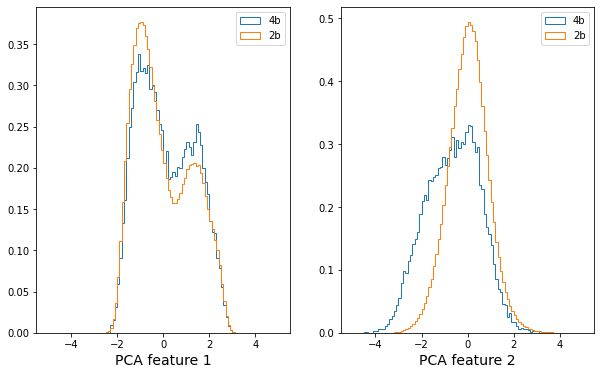

In [39]:
fig, ax = plt.subplots(1, 2, figsize = (10,6))
be = np.linspace(-5, 5, 101)
h,_, _ = ax[0].hist(X_train[Y_train==0]['f1'], bins = be, histtype='step',label='4b', density = True)
_ = ax[0].hist(X_train[Y_train==1]['f1'], bins = be, histtype='step', label = '2b', density = True)
_ = ax[1].hist(X_train[Y_train==0]['f2'], bins = be, histtype='step', label = '4b', density = True)
_ = ax[1].hist(X_train[Y_train==1]['f2'], bins = be, histtype = 'step', label = '2b', density =True)
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('PCA feature 1', fontsize = 14)
ax[1].set_xlabel('PCA feature 2', fontsize = 14)

AttributeError: 'PathCollection' object has no property 'fmt'

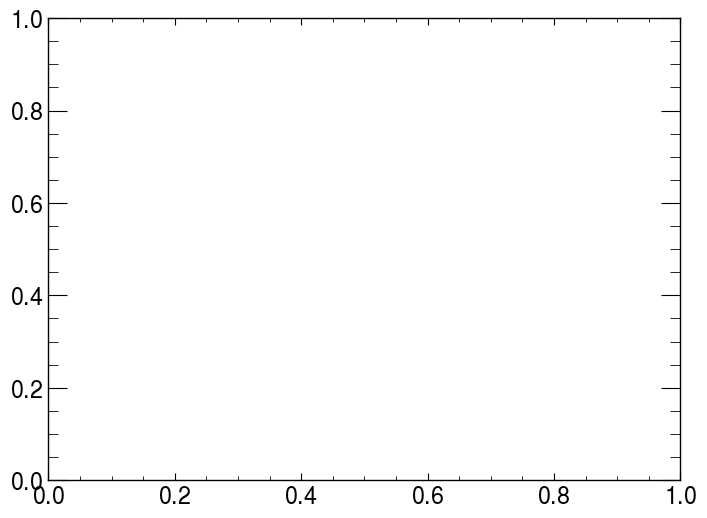

In [122]:
plt.scatter(X_train[Y_train==0]['f1'].values, X_train[Y_train==0]['f2'].values, fmt='+', label = '4b')
plt.scatter(X_train[Y_train==1]['f1'].values, X_train[Y_train==1]['f2'].values,fmt='.', label = '2b')

In [40]:
scaler = StandardScaler()

In [41]:
X_train_f = X_train[['f1','f2']]
X_test_f = X_test[['f1','f2']]

In [42]:
X_TRAIN = scaler.fit_transform(X_train_f)
X_TEST = scaler.transform(X_test_f)

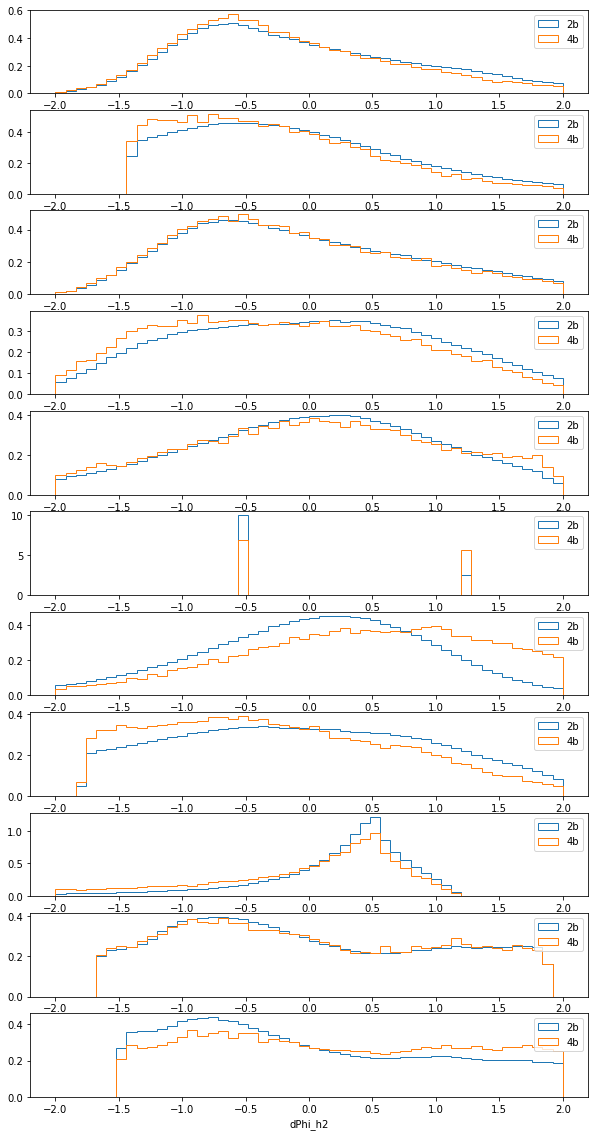

In [155]:
nf = len(features_to_rw['rw_cols_log'])
f, ax = plt.subplots(1, 2, figsize= (10, 20))
be = np.linspace(-2, 2, 51)
for i, feature in enumerate(['rw_cols_log']):
    _= ax[i].hist(X_train_2b[feature].values, bins = be,histtype='step',label = '2b',density=True)
    _ =ax[i].hist(X_train_4b[feature].values, bins = be, histtype='step', label = '4b', density=True)
    ax[i].set_xlabel(feature)
    ax[i].legend()

In [70]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=X_TRAIN.shape[1]),
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dense(1, activation="linear"),
    ]
)

In [71]:
import tensorflow.keras.backend as K

In [72]:
def louppe_loss_tf2(y_true, y_pred):
    return (y_true * (K.sqrt(K.exp(y_pred))) + (1.0 - y_true) * (1.0 / K.sqrt(K.exp(y_pred))))

In [73]:
model.compile(loss=louppe_loss_tf2, metrics = ['accuracy'], optimizer='adam')

In [74]:
X_TRAIN

array([[ 0.34337251,  0.31307511],
       [-1.07545451, -1.19279618],
       [ 1.05288148, -1.02057413],
       ...,
       [-1.08108037, -1.05830203],
       [-0.77913949,  0.4349366 ],
       [ 1.0079196 , -0.11705973]])

In [77]:
history = model.fit(X_TRAIN, Y_train,
                    callbacks = [
                            EarlyStopping(monitor='val_loss', patience=10, verbose=True),
                            ModelCheckpoint('model.h5', monitor='val_loss', verbose=True, save_best_only=True) ],
                            epochs=500,
                            validation_data=(X_TEST, Y_test),
                            batch_size=8192,
                   )

Train on 1414659 samples, validate on 353665 samples
Epoch 1/500
1327104/1414659 [===========================>..] - ETA: 0s - loss: 0.2391 - accuracy: 0.0168
Epoch 00001: val_loss improved from inf to 0.24081, saving model to model.h5
1414659/1414659 [==============================] - 1s 0us/sample - loss: 0.2391 - accuracy: 0.0168 - val_loss: 0.2408 - val_accuracy: 0.0170
Epoch 2/500
1335296/1414659 [===========================>..] - ETA: 0s - loss: 0.2394 - accuracy: 0.0168
Epoch 00002: val_loss did not improve from 0.24081
1414659/1414659 [==============================] - 1s 0us/sample - loss: 0.2392 - accuracy: 0.0168 - val_loss: 0.2410 - val_accuracy: 0.0170
Epoch 3/500
1335296/1414659 [===========================>..] - ETA: 0s - loss: 0.2390 - accuracy: 0.0167
Epoch 00003: val_loss did not improve from 0.24081
1414659/1414659 [==============================] - 1s 0us/sample - loss: 0.2391 - accuracy: 0.0168 - val_loss: 0.2412 - val_accuracy: 0.0170
Epoch 4/500
1335296/1414659 [=

In [78]:
model.load_weights('model.h5')

In [79]:
Y_train==0

array([False, False, False, ..., False, False, False])

In [80]:
X_val = X_train[['f1','f2']][-5000:].values

In [81]:
X_val

array([[ 1.05228677, -1.65485435],
       [-0.36601944, -0.44021447],
       [-1.1681179 , -0.22796751],
       ...,
       [-1.32409827, -0.92516611],
       [-0.95428358,  0.38022095],
       [ 1.23449156, -0.10233345]])

In [82]:
X_val.shape

(5000, 2)

In [83]:
e = shap.DeepExplainer(model, X_val)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [84]:
X_train[39]

KeyError: 39

In [85]:
shap_values = e.shap_values(X_val)

In [86]:
X_train.shape

(1414659, 13)

In [87]:
len(features_to_rw['rw_cols_log'])

11

In [49]:
help(shap.summary_plot)

Help on function summary_legacy in module shap.plots._beeswarm:

summary_legacy(shap_values, features=None, feature_names=None, max_display=None, plot_type=None, color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None, color_bar_label='Feature value', cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x7f492bd05080>, auto_size_plot=None, use_log_scale=False)
    Create a SHAP beeswarm plot, colored by feature values when they are provided.
    
    Parameters
    ----------
    shap_values : numpy.array
        For single output explanations this is a matrix of SHAP values (# samples x # features).
        For multi-output explanations this is a list of such matrices of SHAP values.
    
    features : numpy.array or pandas.DataFrame or list
        Matrix of feature values (# samples x # features) or a feature_names list as shorthand
    
    feature_names :

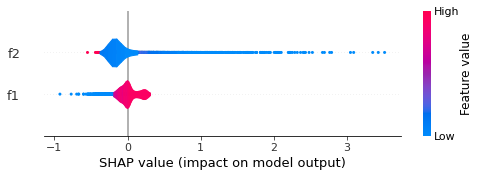

In [88]:
shap.summary_plot(
    shap_values[0], X_val,
    feature_names=['f1','f2'], plot_type="violin"
)

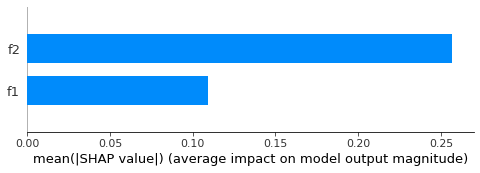

In [89]:
shap.summary_plot(
    shap_values[0], X_val,
    feature_names=['f1','f2'], plot_type="bar"
)

In [91]:
import seaborn as sns

In [92]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="f1", y="f2",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=X_train_pca,
    legend="full",
    alpha=0.3
)


AttributeError: 'numpy.ndarray' object has no attribute 'get'

<Figure size 1152x720 with 0 Axes>

In [73]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [76]:
plt.gcf()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.

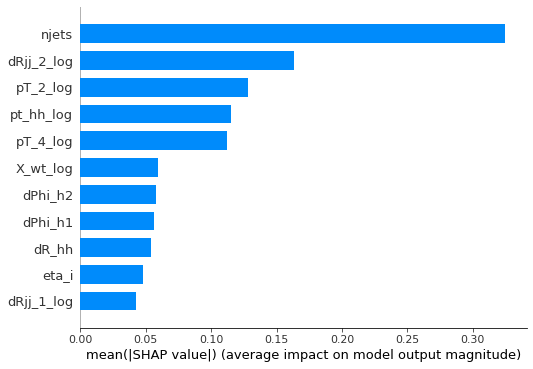

In [80]:
f = shap.summary_plot(
    shap_values[0],
    X_val,
    feature_names=features_to_rw["rw_cols_log"],
    plot_type="bar",
    show=False,
)

In [81]:
plt.savefig("test.pdf")

<Figure size 432x288 with 0 Axes>

![](test.png)

is the model fucked?

In [49]:
df_cr_2b = df_cr.loc[df_cr['ntag']==2]

In [52]:
df_cr[['f1','f2']]

KeyError: "None of [Index(['f1', 'f2'], dtype='object')] are in the [columns]"

In [93]:
print("hi")

hi


In [94]:
X = pca.transform(df_cr_2b[features_to_rw['rw_cols_log']].values)

In [96]:
X = scaler.transform(X)

In [97]:
X

array([[-0.84515635, -0.69820989],
       [ 1.65979435, -0.02976453],
       [ 0.0169586 ,  0.09330287],
       ...,
       [-0.92261349, -0.24554394],
       [-0.67864369, -0.90954749],
       [ 0.07493548,  2.13993533]])

In [98]:
pred = model.predict(X, batch_size=8192)

In [99]:
df_cr_2b['NN_weight'] = np.exp(pred)[:,0]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [101]:
df_cr_2b.ntag.value_counts()

2    1738549
Name: ntag, dtype: int64

In [102]:
df_cr = df_cr.merge(
    df_cr_2b[["event_number", "run_number", "NN_weight"]],
    how="left",
    on=["event_number", "run_number"],
)

In [103]:
df_cr['NN_weight'].isna().value_counts()

False    1738549
True       52224
Name: NN_weight, dtype: int64

In [104]:
df_cr.fillna({'NN_weight':1}, inplace = True)

In [106]:
from eda_tools.utilities import getNorm

In [107]:
help(getNorm)

Help on function getNorm in module eda_tools.utilities:

getNorm(df, k, verbose=False, weight_column=None)
    Return the 2b -> 4b normalization in a specified kinematic region
    
    Inputs:
    - df: pandas df for data events
    - k: The kinematic region to calculate this normalization in
         * 2: SB
         * 1: CR
    - verbose: Prints out the value of 4b, 2b and ratio. Return type includes 4b and 2b values



In [108]:
muQCD = getNorm(df_cr, k=2, weight_column='NN_weight')

In [111]:
import mplhep as hep
hep.set_style('ATLAS')

Text(0.5, 1.0, 'PCA encoded reweighting')

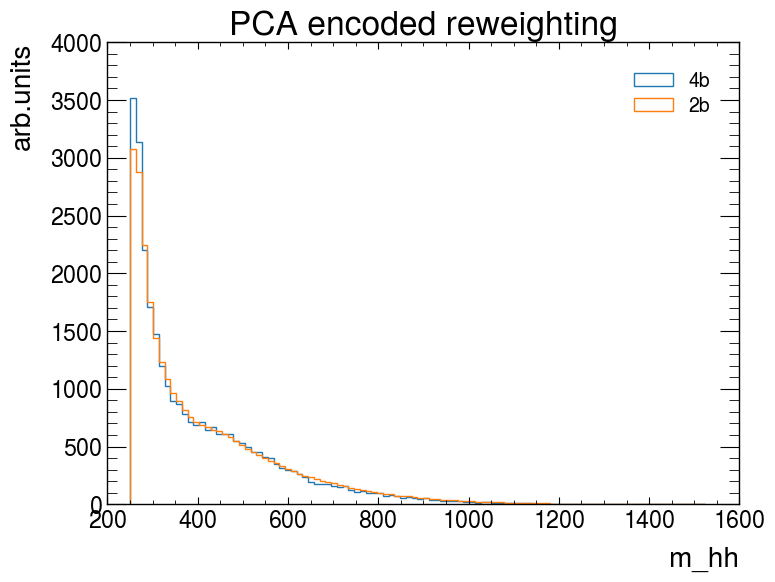

In [114]:

_,be,_ =plt.hist(df_cr.loc[df_cr.ntag>=4,'m_hh_cor'].values,
                bins = 100,
                histtype='step',
                label = '4b'
               )
_,_,_ = plt.hist(df_cr.loc[df_cr.ntag==2,'m_hh_cor'].values,
                bins = be, 
                histtype='step',
                label = '2b',
                weights=muQCD * df_cr.loc[df_cr.ntag==2,'NN_weight'].values
                )
plt.legend()
plt.xlabel('m_hh')
plt.ylabel('arb.units')
plt.title('PCA encoded reweighting')

model seems to work just fine.

# Debug Ideas

save model summary to file

In [87]:
def myprint(s):
    with open('modelsummary.txt','w+') as f:
        print(s, file=f)
        
model.summary(print_fn=myprint)

In [84]:
model.summary(print_fn=myprint)

In [88]:
!cat modelsummary.txt

_________________________________________________________________


In [86]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                600       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 5,751
Trainable params: 5,751
Non-trainable params: 0
_________________________________________________________________


In [89]:
from contextlib import redirect_stdout

with open('modelsummary2.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

In [90]:
!cat modelsummary2.txt

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                600       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 5,751
Trainable params: 5,751
Non-trainable params: 0
_________________________________________________________________


In [91]:
with open('modelsummary3.txt', 'w') as f:

    model.summary(print_fn=lambda x: f.write(x + '\n'))

In [92]:
!cat modelsummary3.txt

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                600       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 5,751
Trainable params: 5,751
Non-trainable params: 0
_________________________________________________________________


In [95]:
len(features_to_rw["rw_cols_log"])

11